<a href="https://colab.research.google.com/github/kartoone/cosc470/blob/main/keras/mnist-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras import ops

In [2]:
def reset_model(model):
    new_model = keras.models.clone_model(model)
    new_model.build(model.input_shape)  # Build the model with the same input shape
    return new_model

In [5]:
import numpy as np
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(np.shape(x_train))
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

#x_train = x_train.reshape(60000, (28,28,1)).astype("float32") / 255
#x_test = x_test.reshape(10000, (28,28,1)).astype("float32") / 255


(60000, 28, 28)


In [6]:
# example of loading the mnist dataset
from matplotlib import pyplot

# plot images from the training dataset
# n_samples must be a multiple of 5
def show_samples(samples, n_samples, reverse=True):
	cmap = 'gray_r' if reverse else 'gray'
	for i in range(n_samples):
		# define subplot
		pyplot.subplot(5, 5, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		if len(samples[i]) == 2:
			pyplot.imshow(samples[0][i].reshape(28,28), cmap=cmap)
		else:
			pyplot.imshow(samples[i], cmap=cmap)
	pyplot.show()

In [7]:
import keras
from keras import layers

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = keras.Sequential(
     [
        layers.Input(shape=in_shape),
        layers.Conv2D(64, 3, strides=2),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(64, 3, strides=2),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
     ]
  )
	model = reset_model(model)
	# compile model
	opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
	return model

In [8]:
model = define_discriminator()
# summarize the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 13, 13, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,873 (155.75 KB)

 Trainable params: 39,873 (155.75 KB)

 Non-trainable params: 0 (0.00 B)

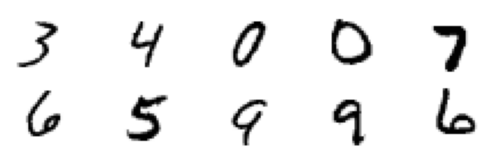

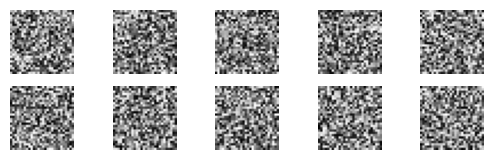

In [36]:
import numpy as np
import numpy.random as npr

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = npr.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = npr.rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

real_X, real_y = generate_real_samples(x_train, 10)
fake_X, fake_y = generate_fake_samples(10)

show_samples(real_X, 10)
show_samples(fake_X, 10)

In [10]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		real = model.train_on_batch(X_real, y_real, return_dict=True)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		fake = model.train_on_batch(X_fake, y_fake, return_dict=True)
	print(real)
	print(fake)
# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model, x_train)



{'binary_accuracy': array(0.9333778, dtype=float32), 'loss': array(0.20019777, dtype=float32)}
{'binary_accuracy': array(0.93371093, dtype=float32), 'loss': array(0.19921644, dtype=float32)}


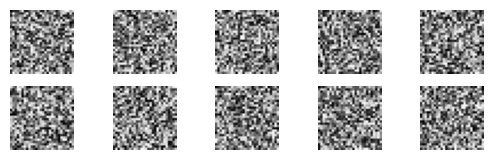

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
[0.00189674]
[0.00120075]
[0.00214282]
[0.00117843]
[0.00100803]
[0.00143722]
[0.00235434]
[0.00281644]
[0.00211888]
[0.0013904]


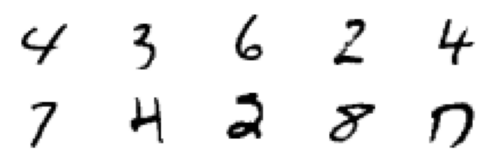

(10, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0.9815036]
[0.9875097]
[0.9869489]
[0.9863382]
[0.99237204]
[0.9906639]
[0.9793594]
[0.9968029]
[0.9934437]
[0.9188795]


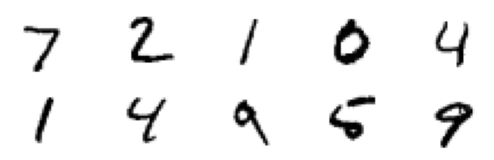

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[0.99007493]
[0.96505994]
[0.9652414]
[0.99950457]
[0.9873641]
[0.9880378]
[0.98454446]
[0.9893199]
[0.9931953]
[0.99873275]


In [11]:
X_fake, y_fake = generate_fake_samples(10)
X_real, y_real = generate_real_samples(x_train, 10)
show_samples(X_fake, 10)
results = model.predict(X_fake)
for i in range(10):
    print(results[i])

show_samples(X_real, 10)
print(X_real.shape)
results = model.predict(X_real)
for i in range(10):
    print(results[i])

show_samples(x_test, 10)
results = model.predict(x_test)
for i in range(10):
    print(results[i])

In [12]:
correct = 0
for i in range(10000):
    if results[i][0] > 0.5:
        correct += 1
print(correct)

10000


**The major problem at this point is if we input a "scribble" instead of random noise** then the discriminator is likely to classify it as a real image.

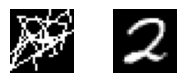

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.6370863]
 [0.9604222]]


In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

file_list = ["scribble_28x28_new.png"]
X_test = []
for file in file_list:  # Load only the first 3 images
    image = Image.open(file).convert("L")  # Convert to grayscale
    image_array = 1-np.array(image, dtype=np.float32) / 255.0  # Normalize and convert to reverse grayscale
    image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension
    X_test.append(image_array)
X_test.append(x_test[35])
X_test = np.array(X_test)

show_samples(X_test, 2, False)

result = model.predict(X_test)
print(result)

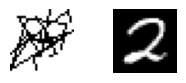

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[4.4112358e-06]
 [9.6042222e-01]]


In [26]:
# this illustrates the problem ... chatGPT generated a regular grayscale image ... without the 1 - ... this is what you get
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

file_list = ["scribble_28x28_new.png"]
X_test = []
for file in file_list:  # Load only the first 3 images
    image = Image.open(file).convert("L")  # Convert to grayscale
    image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize and convert to reverse grayscale
    image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension
    X_test.append(image_array)
X_test.append(x_test[35])
X_test = np.array(X_test)

show_samples(X_test, 2, False)

result = model.predict(X_test)
print(result)

**NOW LET'S WORK ON THE GENERATOR!**

In [38]:
# example of training a gan on mnist
import numpy as np
import keras
from keras import layers

# define the standalone discriminator model
def define_generator(latent_dim):
	model = keras.Sequential(
     [
         layers.Input(shape=(latent_dim,)),
         layers.Dense(128 * 7 * 7),
         layers.LeakyReLU(negative_slope=0.2),
         layers.Reshape((7, 7, 128)),
         layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
         layers.LeakyReLU(negative_slope=0.2),
         layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
         layers.LeakyReLU(negative_slope=0.2),
         layers.Conv2D(1, (7,7), activation='sigmoid', padding='same')
     ]
	)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = keras.Sequential([g_model, d_model])
	# compile model
	opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data (already loaded into x_train)
# train model
train(g_model, d_model, gan_model, x_train, latent_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


>1, 1/234, d=0.696, g=0.674
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>1, 2/234, d=0.699, g=0.669
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>1, 3/234, d=0.699, g=0.669
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>1, 4/234, d=0.700, g=0.669
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 5/234, d=0.700, g=0.668
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 6/234, d=0.700, g=0.668
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 7/234, d=0.701, g=0.667
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 8/234, d=0.701, g=0.666
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 9/234, d=0.702, g=0.665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 10/234, d=0.703, g=0.664
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 11/234, d=0.704, g=0.662
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 12/234, d=0.705, g=0.660
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 13/234, d=0.706, g=0.658
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 14/234, d=0.707, g=0.656
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 15/234, d=0.709, g=0.654
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>11, 1/234, d=1.100, g=0.358
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>11, 2/234, d=1.061, g=0.358
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>11, 3/234, d=1.042, g=0.358
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>11, 4/234, d=1.032, g=0.358
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>11, 5/234, d=1.027, g=0.358
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>11, 6/234, d=1.023, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>11, 7/234, d=1.019, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>11, 8/234, d=1.017, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>11, 9/234, d=1.016, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>11, 10/234, d=1.013, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>11, 11/234, d=1.012, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>11, 12/234, d=1.011, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>11, 13/234, d=1.009, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>11, 14/234, d=1.009, g=0.357
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>11, 15/234, d=1.00

KeyboardInterrupt: 